1) Author: Jaydeep Samanta

2) This code is an attempt to implement a model as proposed by the paper "Age and Gender Prediction From Face Images Using Attentional Convolutional Network" https://arxiv.org/abs/2010.03791, which is a multi-task learning framework to jointly predict the age and gender of individuals from their face images. The idea is to develop an ensemble of Attentional CNN model and a Resnet model(Residual network). 

I took inspiration from multiple sources as cited below:

- Attention CNN model https://bit.ly/3KLDuG0

- Resnet-34 Model code is taken from the book: "Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow" by Aurélien Géron at page 478. Also referred https://datasciencemystic.com/custom-resnet-34-model-for-image-classification/ for understanding and customizing resnet models

- To understand and experiment using simple CNN models https://www.analyticsvidhya.com/blog/2021/07/age-and-gender-detection-using-deep-learning/



In [ ]:
# Import libraries
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling2D,Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,mean_absolute_error

## Data-Set

For this project I am using the UTK image data-set cropped version

https://susanqq.github.io/UTKFace/

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = "/content/gdrive/MyDrive/crop_part1_1/crop_part1"

Extracting, age and gender information from the image names

In [ ]:
# Extracting age, gender and images from the image folder
# Creting a list of each values
images = []
age = []
gender = []
for img in os.listdir(path):
  image_array = cv2.imread(os.path.join(path,img))
  age.append(int(img.split('_')[0]))
  gender.append(int(img.split('_')[1]))
  images.append(image_array)

In [ ]:
# Creating output file which will have age and gender information
labels=[]
for i in range(len(age)):
    label = [age[i], gender[i]]
    labels.append(label)

In [ ]:
# Converting input images and labels into numpy arrays
images = np.array(images)   
labels = np.array(labels)

In [ ]:
# Printing shape of images and labels
print(images.shape)
print(labels.shape)

(9780, 200, 200, 3)
(9780, 2)


In [ ]:
# Plot some pictures from the image data-set along with labels
# 0 - Male
# 1 - Female
def showImagesAge(images,labels):
    plt.figure(figsize=[22,15])
    for i in range(500,525):
        plt.subplot(5,5,(i%25)+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        plt.title("Age is {} Gender is {}".format(labels[i][0], labels[i][1]))
        plt.axis('off')
    plt.show()

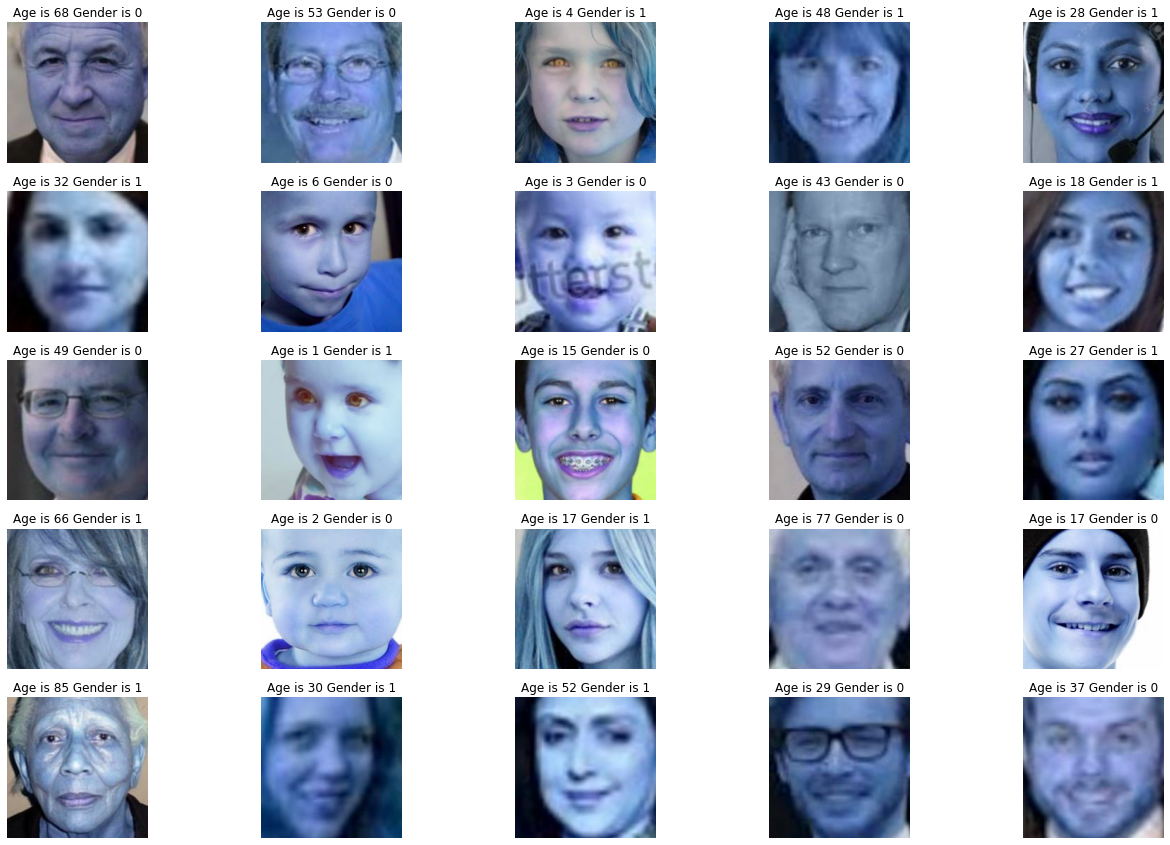

In [ ]:
showImagesAge(images,labels)

In [ ]:
age_unique, age_counts = np.unique(age, return_counts=True)
dictionary = dict(zip(age_unique, age_counts))
g_unique, g_counts = np.unique(gender, return_counts=True)
g_dictionary = {'Male':g_counts[0], 'Female':g_counts[1]}

# Calculate the samples count per each age group.
age_list = ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40',
            '41-45', '46-50', '51-55', '56-60', '61-65', '66-70', '71-75', '76-80',
            '81-85', '86-90', '91-95', '96-100', '100+']
age_count = []
for i in range(21):
    sum_here = 0
    for j in range(1,6,1):
        if ((i*5)+j) in age_unique:
            sum_here = sum_here + dictionary[(i*5)+j]
    age_count.append(sum_here)
dictionary = dict(zip(age_list, age_count))

Age distribution

Text(0.5, 1.0, 'Numer of samples per age group')

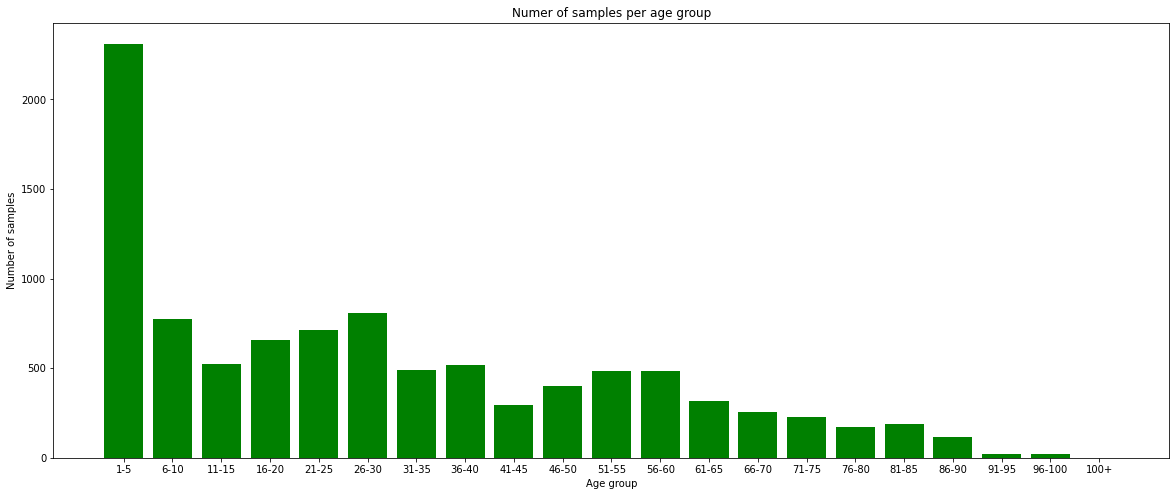

In [ ]:
keys = dictionary.keys()
values = dictionary.values()

# Plot the graph samples per age group.
f, ax = plt.subplots(figsize=(20, 8)) 
plt.bar(keys, values, align='center', color = 'green')
ax.set_ylabel('Number of samples')
ax.set_xlabel('Age group')
ax.set_title('Numer of samples per age group')

Gender class

Text(0.5, 1.0, 'Numer of samples per each Gender')

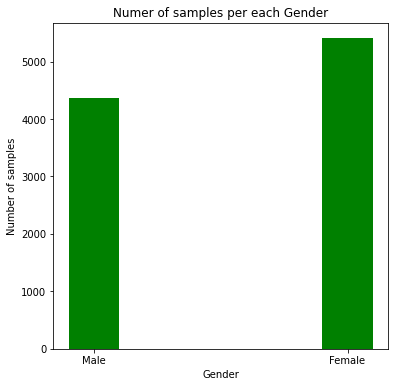

In [ ]:
keys = g_dictionary.keys()
values = g_dictionary.values()

# Plot the graph samples per each gender.
f, ax = plt.subplots(figsize=(6, 6)) 
plt.bar(keys, values, width = 0.2,  color = 'green')
ax.set_ylabel('Number of samples')
ax.set_xlabel('Gender')
ax.set_title('Numer of samples per each Gender')

### Resizing the image files for faster processing

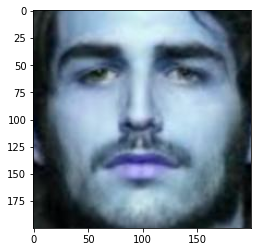

In [ ]:
# Drawing sample . 
plt.imshow(images[100])

Re-sizing the input image from 200x200 to 64x64 for faster training

In [ ]:
# Checking first for a single image file
img = images[100]
scale_percent = 32 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
    
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
#resized_img.append(resized)
  
print('Resized Dimensions : ',resized.shape)

Resized Dimensions :  (64, 64, 3)


In [ ]:
# Using above code to re-size all images
resized_img = []
for img in images:
 
  scale_percent = 32 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
    
  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  resized_img.append(resized)
  
  #print('Resized Dimensions : ',resized.shape)


In [ ]:
# Printing the re-sized image 
resized_img[0].shape

(64, 64, 3)

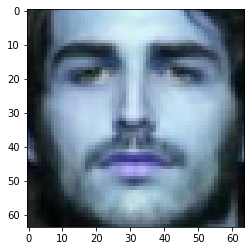

In [ ]:
# Drawing sample . 
plt.imshow(resized_img[100])

In [ ]:
# Converting it to numpy array
resized_img = np.array(resized_img) 

In [ ]:
resized_img.shape

(9780, 64, 64, 3)

In [ ]:
# Splitting the data-set in training and testing using sklean's train test split
X_train, X_test, y_train, y_test = train_test_split(resized_img, labels, test_size=0.25, random_state=42)

In [ ]:
# Normalize the data by dividing it by 255
X_train = X_train/255
y_train = y_train/255

Attention CNN model

I took inspiration from the github repro for the attentional CNN model

https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb

It has two classes: 

1) Channel Attention

2) Spatial Attention

In [ ]:
class ChannelAttention(keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = keras.layers.GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = keras.layers.Add()([avg_pool,max_pool])
            attention = keras.layers.Activation('sigmoid')(attention)
            
            return keras.layers.Multiply()([inputs, attention])

In [ ]:
class SpatialAttention(keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return keras.layers.multiply([inputs, attention])  

Below we create a simple CNN model with attention layers defined above

In [ ]:
simple_cnn_with_attention = keras.models.Sequential([
    keras.layers.Conv2D(32, 3, input_shape=(64,64,3), activation='elu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, 3, padding='same', activation='elu'),
    keras.layers.BatchNormalization(),
    ChannelAttention(32, 8),
    SpatialAttention(7),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    keras.layers.BatchNormalization(),
    ChannelAttention(64, 8),
    SpatialAttention(7),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    ChannelAttention(128, 8),
    SpatialAttention(7)
])

In [ ]:
# Displaying the summary of the model
simple_cnn_with_attention.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 channel_attention (ChannelA  (None, 64, 64, 32)       0         
 ttention)                                                       
                                                        

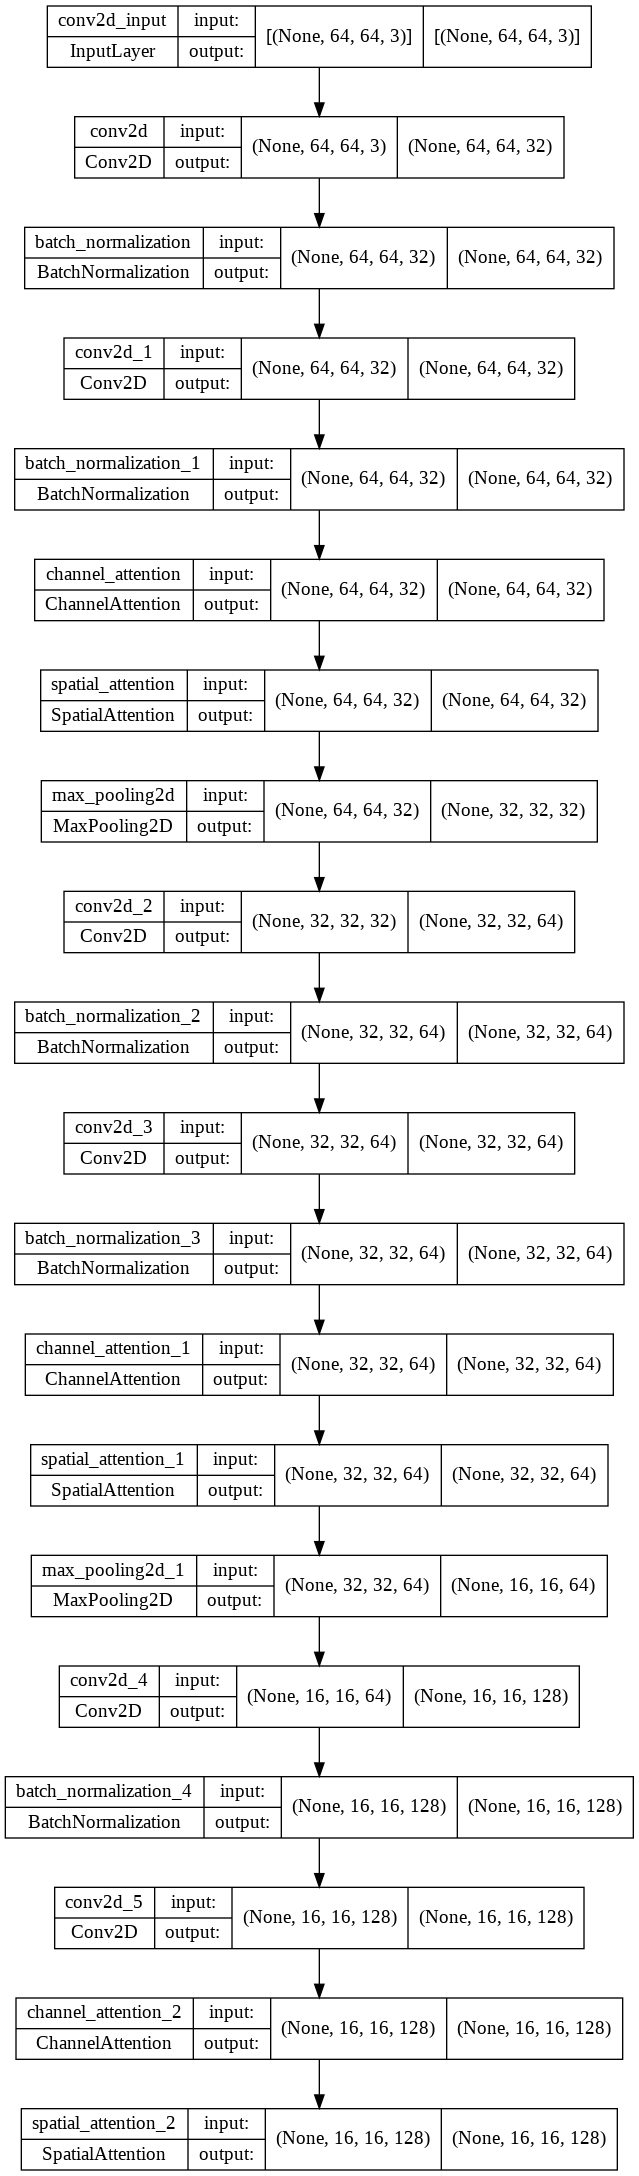

In [ ]:
# Plotting the Attention model to visualize
plot_model(simple_cnn_with_attention, show_shapes=True)

Resnet-34 Model

Below code is taken from the book: "Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow" by Aurélien Géron at page 478

Also refered https://datasciencemystic.com/custom-resnet-34-model-for-image-classification/ for understanding and customizing resnet models

In [ ]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

        def call(self, inputs):
            Z = inputs
            for layer in self.main_layers:
                Z = layer(Z)
            skip_Z = inputs
            for layer in self.skip_layers:
                skip_Z = layer(skip_Z)
            return self.activation(Z + skip_Z)
        
        def get_config(self):
            base_config= super().get_config()
            return {**base_config, 
                    "filters": self.filters, 
                    "activation":self.activation,
                    "strides": self.strides
                   }

In [ ]:
# We pass the input of Resnet-34 with the output from Attention CNN model
# Output image from Attention CNN is 16*16*128
# Input shape for Resnet-34 is therefore set to 16*16*128

def getModel_ResNet34(layer_activation="relu", 
                 input_shape=(16,16,128),
                 output_dim=2,
                 out_activation="softmax"):
    """ function to implement Renet34 Model"""
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape= input_shape))
    model.add(keras.layers.Conv2D(64,7,strides=2,padding="same",use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(layer_activation))
    model.add(keras.layers.MaxPool2D(pool_size=3,strides=2,padding="same"))
    """ Add bunch(16 units for ResNet34) of ResUnits to increase depth of 
        the network"""
    prev_filter = 64
    for filters in [64]*3+[128]*4+[256]*6+[512]*3:
        strides = 1 if prev_filter == filters else 2
        model.add(ResidualUnit(filters, strides=strides, activation=layer_activation))
        prev_filter = filters
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(output_dim,activation=out_activation))
    return model

In [ ]:
# Creating the resnet model
resnet34_model = getModel_ResNet34()

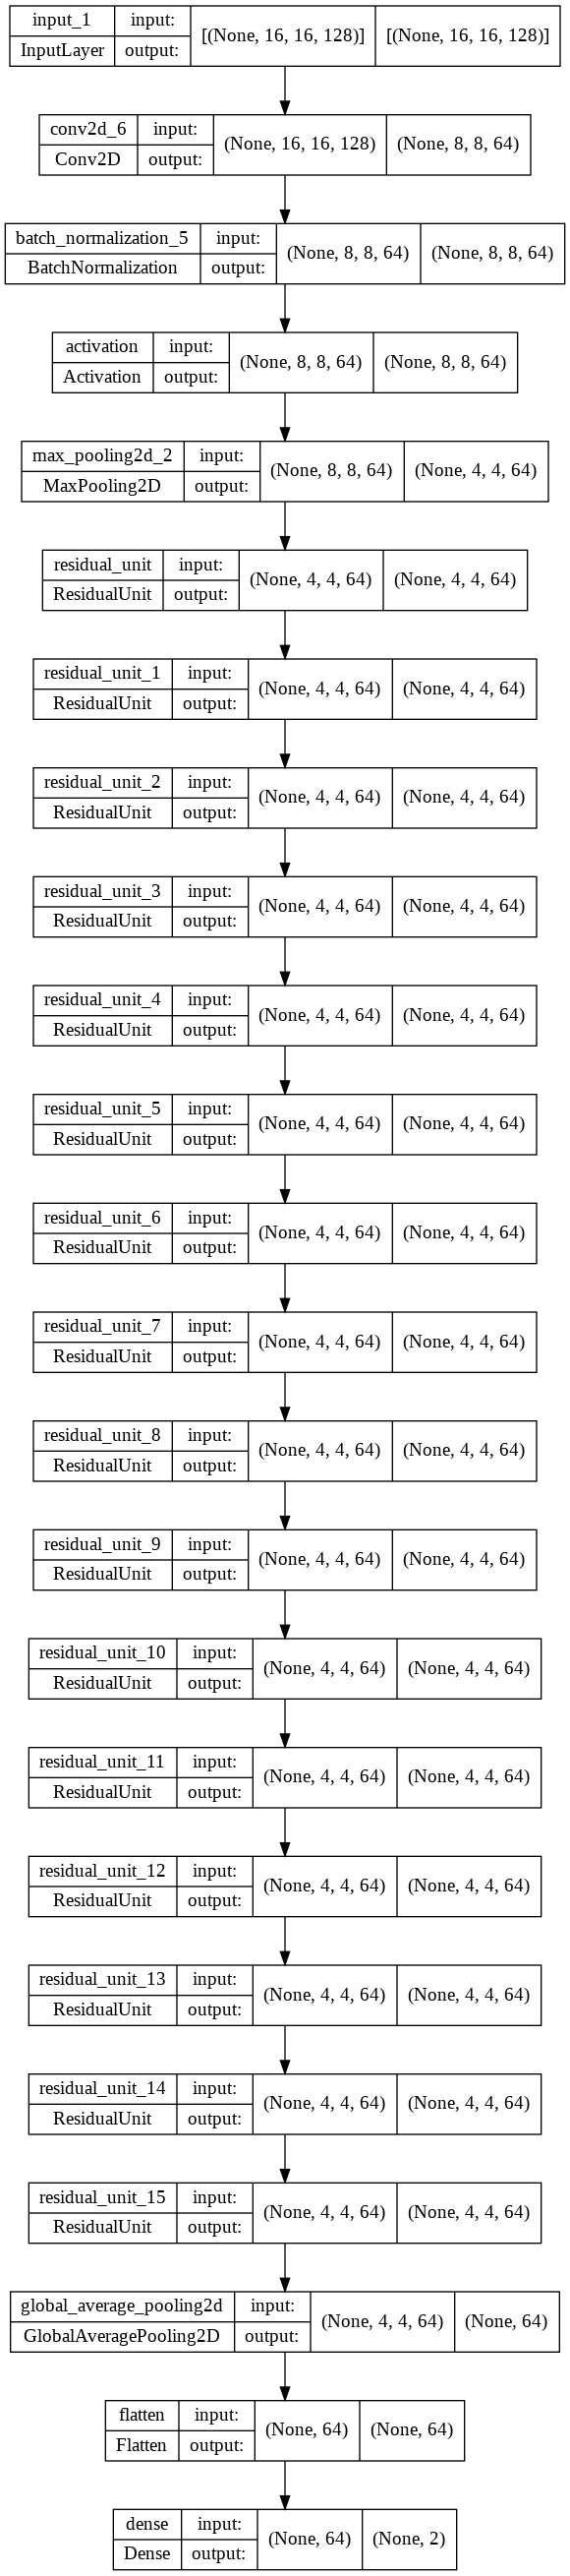

In [ ]:
# Plotting the model to visualize it

plot_model(resnet34_model, show_shapes=True)

In [ ]:
# Displaying the model summary
resnet34_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          401408    
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 8, 8, 64)          0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 4, 4, 64)         0         
 )                                                               
                                                      

## Model 1

We combine both the Attention CNN and Resnet-34 models and create an ensemble model

This model has two outputs - 1) Age and 2) Gender

Ensemble of Attention model and Resnet-34 model

In [ ]:
# Using Keras functional API
# Age and gender have separate output
def ensemble_model(input_shape):

  inputs = keras.Input((input_shape))

  attention_model = simple_cnn_with_attention(inputs)
  
  resnet_attention_model = resnet34_model(attention_model)
  batch_norm_1 = BatchNormalization()(resnet_attention_model)
  dropout_1 = Dropout(0.5)(batch_norm_1)

  flatten = Flatten()(dropout_1)
  
  dense_1 = Dense(512, activation='relu')(flatten)
  batch_norm_2 = BatchNormalization()(dense_1)
  dropout_2 = Dropout(0.5)(batch_norm_2)
  dense_2 = Dense(128, activation='relu')(dropout_2)

  gender_output = Dense(1, activation='sigmoid', name='gender')(dense_2)

  dense_3 = Dense(512, activation='relu')(flatten)
  batch_norm_3 = BatchNormalization()(dense_3)
  dropout_3 = Dropout(0.5)(batch_norm_3)
  dense_4 = Dense(128, activation='relu')(dropout_3)
  
  age_output = Dense(1, activation='relu', name='age')(dense_4)


  model = Model(inputs=[inputs], outputs=[age_output, gender_output])

  return model


In [ ]:
# Passing the input image size to the model
ensemble_model = ensemble_model((64,64,3))

We used Adam optimizer and different loss and metrics for age and gender.

Since age is a linear regression problem and gender is a classification problem.

1) Age:

Loss function: Mean-Squared-error

Metrics: Mean-Squared-error

2) Gender:

Loss function: Binary-Cross_Entropy

Metrics: Accuracy

In [ ]:
ensemble_model.compile(loss=["mae","binary_crossentropy"], optimizer="Adam",metrics=["accuracy"])

In [ ]:
# Displaying the summary of ensemble_model 
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 16, 16, 128)  288288      ['input_2[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 2)            401794      ['sequential[0][0]']             
                                                                                                  
 batch_normalization_41 (BatchN  (None, 2)           8           ['sequential_1[0][0]']           
 ormalization)                                                                                

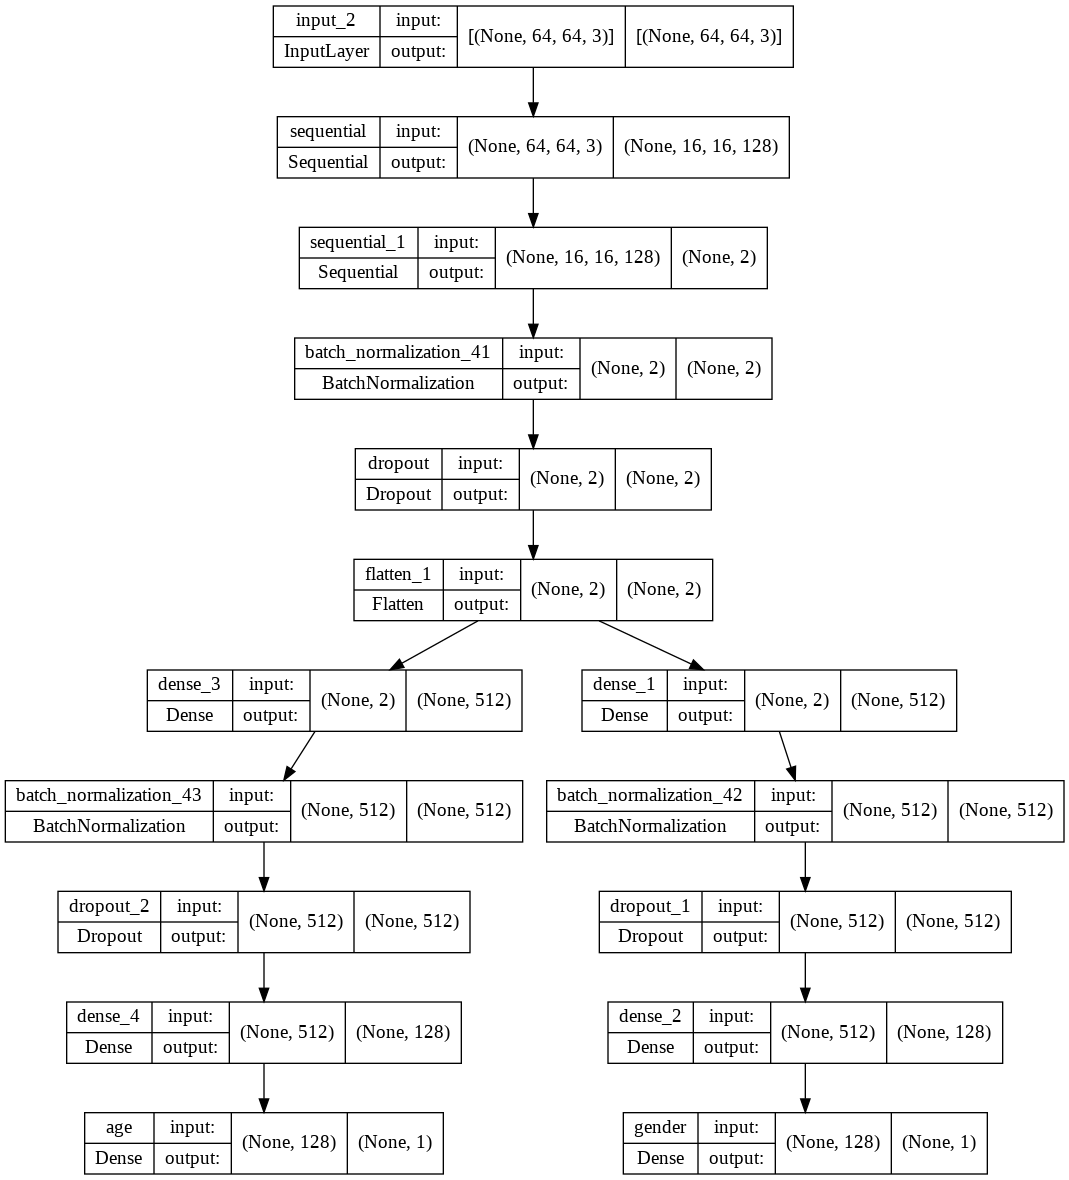

In [ ]:
plot_model(ensemble_model, show_shapes=True)

Next we will change the y_train and y_test shape from list of arrays to a list of two arrays as we now have two outputs to predict, age and gender. So our model now expects two outputs.

In [ ]:
print("y_train: ",y_train)
print("\n")
print("y_test: ",y_test)

y_train:  [[0.36078431 0.00392157]
 [0.00784314 0.        ]
 [0.06666667 0.00392157]
 ...
 [0.00784314 0.        ]
 [0.20392157 0.00392157]
 [0.1254902  0.        ]]


y_test:  [[18  1]
 [33  0]
 [36  0]
 ...
 [50  0]
 [15  1]
 [17  1]]


In [ ]:
y_train_2 = [y_train[:,0], y_train[:,1]]
y_test_2 = [y_test[:,0], y_test[:,1]]

In [ ]:
# Output y_train and y_test will display as
print("y_train: ",y_train_2)
print("\n")
print("y_test: ",y_test_2)

y_train:  [array([0.36078431, 0.00784314, 0.06666667, ..., 0.00784314, 0.20392157,
       0.1254902 ]), array([0.00392157, 0.        , 0.00392157, ..., 0.        , 0.00392157,
       0.        ])]


y_test:  [array([18, 33, 36, ..., 50, 15, 17]), array([1, 0, 0, ..., 0, 1, 1])]


In [ ]:
# Adding early-stopping
es = EarlyStopping(patience= 3, restore_best_weights=True)

In [ ]:
# Running ensemble model to fit the training and test data
history = ensemble_model.fit(X_train, y_train_2, validation_data=(X_test, y_test_2), epochs=5, batch_size=32, callbacks=[es])

Epoch 1/5
230/230 [==============================] - 26s 55ms/step - loss: 0.1547 - age_loss: 0.1177 - gender_loss: 0.0370 - age_accuracy: 0.0000e+00 - gender_accuracy: 0.4477 - val_loss: 30.4612 - val_age_loss: 29.2855 - val_gender_loss: 1.1758 - val_age_accuracy: 0.0000e+00 - val_gender_accuracy: 0.4311
Epoch 2/5
230/230 [==============================] - 11s 50ms/step - loss: 0.1325 - age_loss: 0.1156 - gender_loss: 0.0169 - age_accuracy: 0.0000e+00 - gender_accuracy: 0.4524 - val_loss: 31.6850 - val_age_loss: 29.2855 - val_gender_loss: 2.3996 - val_age_accuracy: 0.0000e+00 - val_gender_accuracy: 0.4311
Epoch 3/5
230/230 [==============================] - 11s 49ms/step - loss: 0.1322 - age_loss: 0.1156 - gender_loss: 0.0166 - age_accuracy: 0.0000e+00 - gender_accuracy: 0.4524 - val_loss: 32.9015 - val_age_loss: 29.2855 - val_gender_loss: 3.6160 - val_age_accuracy: 0.0000e+00 - val_gender_accuracy: 0.4311
Epoch 4/5
230/230 [==============================] - 12s 51ms/step - loss: 0.13

In [ ]:
# Evaluating the model
ensemble_model.evaluate(X_test,y_test_2)

77/77 [==============================] - 2s 20ms/step - loss: 30.4612 - age_loss: 29.2855 - gender_loss: 1.1758 - age_accuracy: 0.0000e+00 - gender_accuracy: 0.4311


[30.46123695373535,
 29.285480499267578,
 1.1757603883743286,
 0.0,
 0.4310838580131531]

From above we can see that the Ensemble model is able to perform well on Gender classification (accuracy - 47%) but performs very poor on the Age, hence the overall loss is very large.

In [ ]:
# Trying out the model to predict age and gender
pred = ensemble_model.predict(X_test)

Predicted Age: 0
Predicted Sex: Female


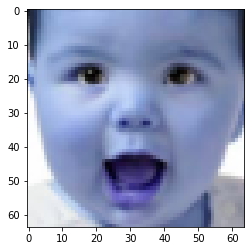

In [ ]:
# Testing on a single image
def test_image(ind,X,Model):
  plt.imshow(X[ind])
  image_test = X[ind]
  pred_1 = Model.predict(np.array([image_test]))
  sex_f = ['Female','Male']
  age=int(np.round(pred_1[1][0]))
  sex=int(np.round(pred_1[0][0]))
  print("Predicted Age: "+ str(age))
  print("Predicted Sex: "+ sex_f[sex])

test_image(101,resized_img, ensemble_model)

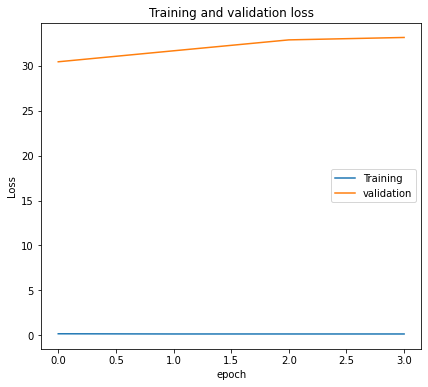

In [ ]:
# Plotting the loss function
plt.figure(figsize=(15,6))

plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['loss'],label = 'Training')
plt.plot(history.epoch,history.history['val_loss'],label = 'validation')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Here from the above plots we can see that the loss is huge and hence the model performance is not so good.

## Model 2

We combine both the Attention CNN and Resnet-34 models and create an ensemble model

This model has two outputs - 1) Age and 2) Gender

But in below model we will create gender model output that we will feed into the age model for prediction as described in the paper.

In [ ]:
# Using Keras functional API
# Gender output is passed to the age model
def ensemble_model_2(input_shape):

  inputs = keras.Input((input_shape))

  attention_model = simple_cnn_with_attention(inputs)

  resnet_attention_model = resnet34_model(attention_model)

  batch_norm_1 = BatchNormalization()(resnet_attention_model)
  dropout_1 = Dropout(0.5)(batch_norm_1)

  flatten = Flatten()(dropout_1)
  
  dense_1 = Dense(512, activation='relu')(flatten)
  batch_norm_2 = BatchNormalization()(dense_1)
  dropout_2 = Dropout(0.5)(batch_norm_2)
  dense_2 = Dense(128, activation='relu')(dropout_2)

  gender_output = Dense(1, activation='sigmoid', name='gender')(dense_2)

  # gender_output is now feed to the age model
  dense_3 = Dense(512, activation='relu')(gender_output)
  batch_norm_3 = BatchNormalization()(dense_3)
  dropout_3 = Dropout(0.5)(batch_norm_3)
  dense_4 = Dense(128, activation='relu')(dropout_3)
  
  age_output = Dense(1, activation='relu', name='age')(dense_4)


  model = Model(inputs=[inputs], outputs=[age_output, gender_output])

  return model


In [ ]:
ensemble_model_2 = ensemble_model_2((64,64,3))

In [ ]:
ensemble_model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 16, 16, 128)       288288    
                                                                 
 sequential_1 (Sequential)   (None, 2)                 401794    
                                                                 
 batch_normalization_44 (Bat  (None, 2)                8         
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 2)                 0         
                                                                 
 flatten_2 (Flatten)         (None, 2)                 0         
                                                           

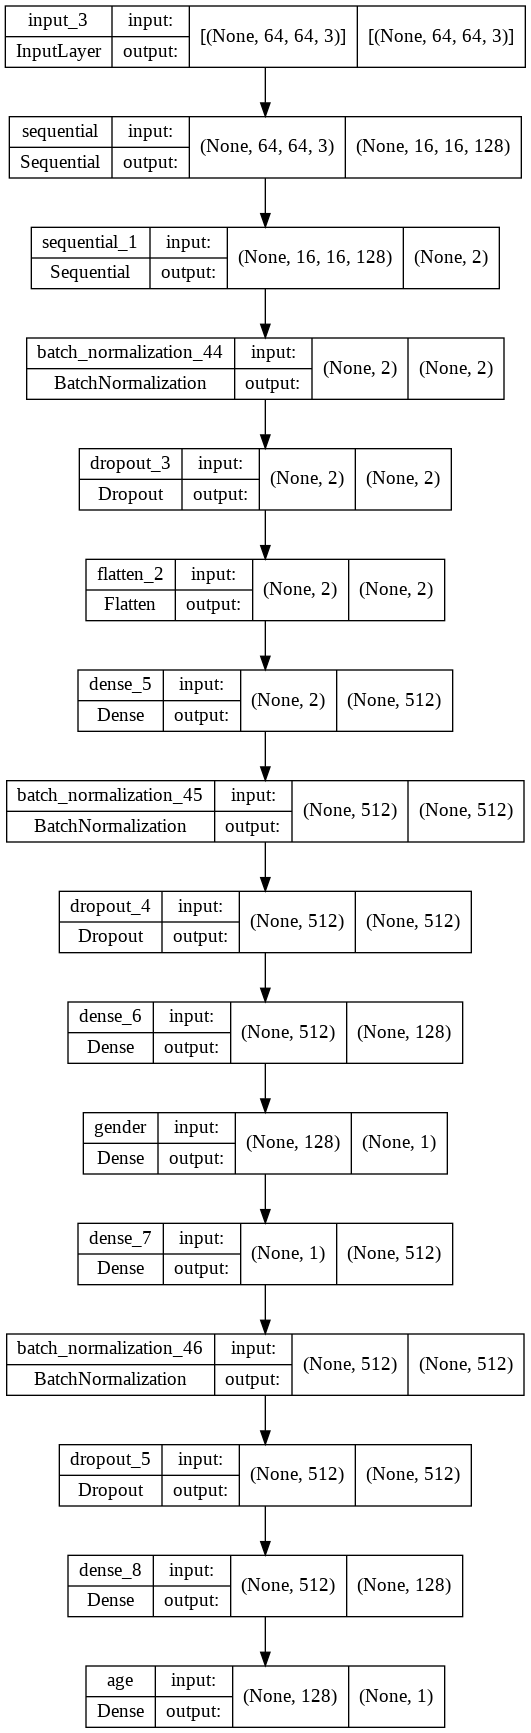

In [ ]:
plot_model(ensemble_model_2, show_shapes=True)

In [ ]:
ensemble_model_2.compile(loss=["mae","binary_crossentropy"], optimizer="Adam",metrics=["accuracy"])

In [ ]:
# Running ensemble model to fit the training and test data
history_2 = ensemble_model_2.fit(X_train, y_train_2, validation_data=(X_test, y_test_2), epochs=5, batch_size=32, callbacks=[es])

Epoch 1/5
230/230 [==============================] - 14s 51ms/step - loss: 0.1057 - age_loss: 0.0844 - gender_loss: 0.0212 - age_accuracy: 0.0000e+00 - gender_accuracy: 0.4522 - val_loss: 30.2995 - val_age_loss: 29.2799 - val_gender_loss: 1.0197 - val_age_accuracy: 0.0000e+00 - val_gender_accuracy: 0.4311
Epoch 2/5
230/230 [==============================] - 11s 49ms/step - loss: 0.0983 - age_loss: 0.0813 - gender_loss: 0.0170 - age_accuracy: 0.0000e+00 - gender_accuracy: 0.4524 - val_loss: 31.3584 - val_age_loss: 29.1915 - val_gender_loss: 2.1669 - val_age_accuracy: 0.0000e+00 - val_gender_accuracy: 0.4311
Epoch 3/5
230/230 [==============================] - 11s 49ms/step - loss: 0.0978 - age_loss: 0.0814 - gender_loss: 0.0165 - age_accuracy: 0.0000e+00 - gender_accuracy: 0.4524 - val_loss: 32.4032 - val_age_loss: 29.1907 - val_gender_loss: 3.2126 - val_age_accuracy: 0.0000e+00 - val_gender_accuracy: 0.4311
Epoch 4/5
230/230 [==============================] - 11s 49ms/step - loss: 0.09

In [ ]:
# Evaluating the model
ensemble_model_2.evaluate(X_test,y_test_2)

77/77 [==============================] - 1s 18ms/step - loss: 30.2995 - age_loss: 29.2799 - gender_loss: 1.0197 - age_accuracy: 0.0000e+00 - gender_accuracy: 0.4311


[30.299530029296875,
 29.279869079589844,
 1.0196566581726074,
 0.0,
 0.4310838580131531]

Here as well the results were not satisfying since the model is dealing with two outputs the loss of age is more and despire the gender loss being less and accuracy close to 47% the overall loss of the model is huge and hence this model does not perform well.

Next we tried to use the Ensemble model (Attention CNN + Resnet-34) separately for Age and gender detection.

## Model3

This model only detects age

In [ ]:
resized_img.shape

(9780, 64, 64, 3)

In [ ]:
age_label = np.array(age)

In [ ]:
age_label.shape

(9780,)

In [ ]:
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(resized_img, age_label, random_state=42)

In [ ]:
# Age model consisting of Attention CNN + ResNet-34
def ensemble_age_model(input_shape):

  inputs = keras.Input((input_shape))

  attention_model = simple_cnn_with_attention(inputs)

  resnet_attention_model = resnet34_model(attention_model)

  batch_norm_1 = BatchNormalization()(resnet_attention_model)
  dropout_1 = Dropout(0.5)(batch_norm_1)

  flatten = Flatten()(dropout_1)
  
  dense_1 = Dense(512, activation='relu')(flatten)
  batch_norm_2 = BatchNormalization()(dense_1)
  dropout_2 = Dropout(0.5)(batch_norm_2)
  dense_4 = Dense(128, activation='relu')(dropout_2)
  
  age_output = Dense(1, activation='relu', name='age')(dense_4)


  model = Model(inputs=[inputs], outputs=[age_output])

  return model

In [ ]:
ensemble_age_model = ensemble_age_model((64,64,3))

In [ ]:
ensemble_age_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 16, 16, 128)       288288    
                                                                 
 sequential_1 (Sequential)   (None, 2)                 401794    
                                                                 
 batch_normalization_47 (Bat  (None, 2)                8         
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 2)                 0         
                                                                 
 flatten_3 (Flatten)         (None, 2)                 0         
                                                           

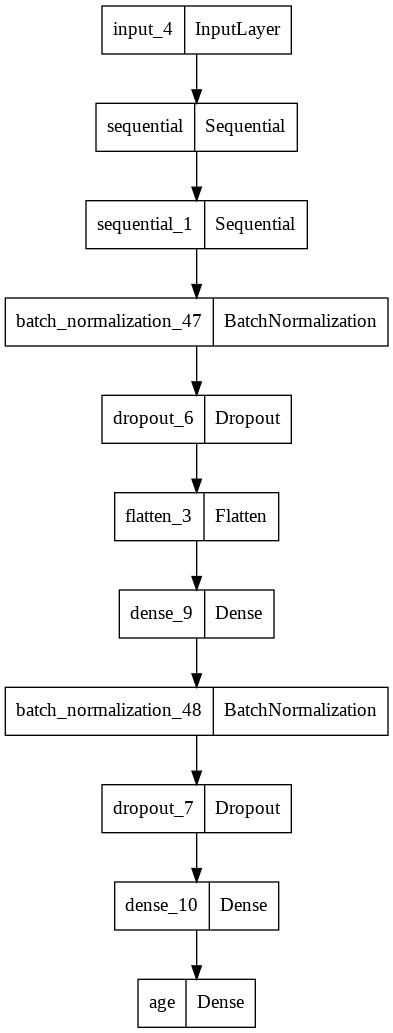

In [ ]:
plot_model(ensemble_age_model, show_shapes=False)

Now, we will compile and train this model using the data-set we created for Age.

In [ ]:
ensemble_age_model.compile(loss=["mae"], optimizer="Adam",metrics=["mae"])

In [ ]:
history_age = ensemble_age_model.fit(x_train_age, y_train_age,
                        validation_data=(x_test_age, y_test_age), epochs=50)

Epoch 1/50
230/230 [==============================] - 13s 47ms/step - loss: 20.4794 - mae: 20.4794 - val_loss: 25.7413 - val_mae: 25.7413
Epoch 2/50
230/230 [==============================] - 11s 46ms/step - loss: 18.3520 - mae: 18.3520 - val_loss: 22.4848 - val_mae: 22.4848
Epoch 3/50
230/230 [==============================] - 11s 46ms/step - loss: 16.6126 - mae: 16.6126 - val_loss: 16.5276 - val_mae: 16.5276
Epoch 4/50
230/230 [==============================] - 11s 46ms/step - loss: 15.2603 - mae: 15.2603 - val_loss: 14.3595 - val_mae: 14.3595
Epoch 5/50
230/230 [==============================] - 11s 47ms/step - loss: 14.3925 - mae: 14.3925 - val_loss: 15.5075 - val_mae: 15.5075
Epoch 6/50
230/230 [==============================] - 11s 46ms/step - loss: 13.8221 - mae: 13.8221 - val_loss: 15.7696 - val_mae: 15.7696
Epoch 7/50
230/230 [==============================] - 11s 46ms/step - loss: 13.4923 - mae: 13.4923 - val_loss: 16.3391 - val_mae: 16.3391
Epoch 8/50
230/230 [==============

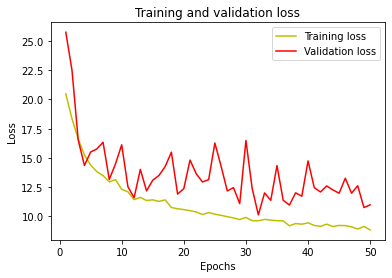

In [ ]:
history = history_age

# Plot the training and validation and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Here we can see the Validation loss keeps reducing and tries to generalize with the training loss but it is very uneven and spiky.

In [ ]:
pred_Age = ensemble_age_model.predict(x_test_age, verbose=1)

77/77 [==============================] - 1s 14ms/step


In [ ]:
pred_age = []
for i in pred_Age:
    pred_age.append(np.round(i[0]))

In [ ]:
def plotAgePA(image,pred,actual):
    plt.figure(figsize=[22,15])
    for i in range(500,525):
        plt.subplot(5,5,(i%25)+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x_test_age[i])
        plt.xlabel(f"Actual Age is {actual[i]}")
        plt.ylabel(f"Prediced is {pred[i]}")
    plt.show()

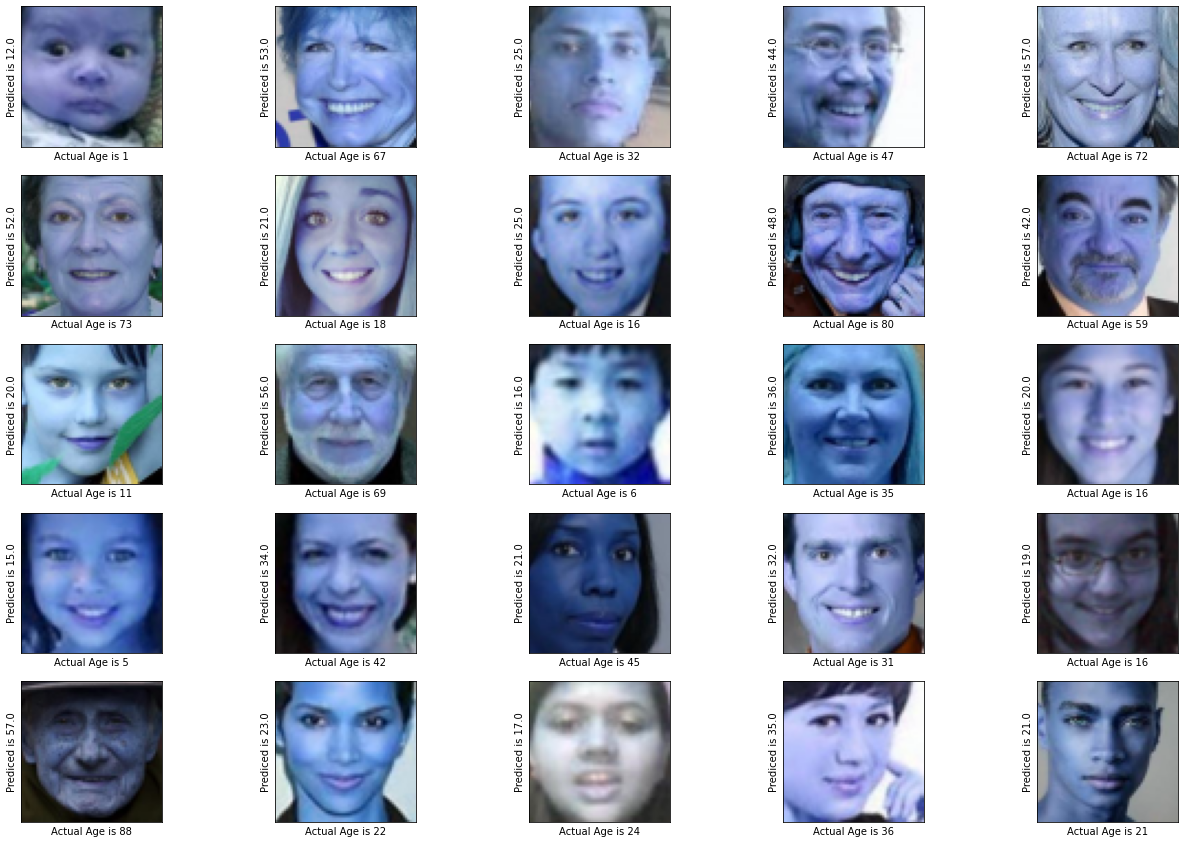

In [ ]:
plotAgePA(x_test_age,pred_age,y_test_age)

Here we can see with single age output the model did performed well as compared to the combined architecture, most of the ages are correctly predicted. If we further train the model with more epochs then we might also get good results.

K-Fold Cross Validation

KFold divides all the samples in k groups of samples, called folds (if , this is equivalent to the Leave One Out strategy), of equal sizes (if possible). The prediction function is learned using k-1 folds, and the fold left out is used for test.

In this case we divided the data into 10 folds.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

In [ ]:
# We will split the data into 10 folds to train
strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(x_test_age, y_test_age)
scores = []
mse_scores = []

# Iterate through each k value and test, train data
for k, (train, test) in enumerate(kfold):
  ensemble_age_model.fit(x_test_age[train], y_test_age[train])
  pred_age = ensemble_age_model.predict(x_test_age[test])
  y_pred_age = np.around(pred_age)
  score = accuracy_score(y_test_age[test], y_pred_age)
  scores.append(score)
  score = mean_squared_error(y_test_age[test], y_pred_age)
  mse_scores.append(score)
  print('Fold: %2d, Accuracy: %.3f' % (k+1, score))

#Print the average accuracy with the deviation
print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

 1/69 [..............................] - ETA: 3s - loss: 11.6489 - mae: 11.6489

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


69/69 [==============================] - 3s 43ms/step - loss: 9.7079 - mae: 9.7079
Fold:  1, Accuracy: 286.714
69/69 [==============================] - 3s 42ms/step - loss: 10.0679 - mae: 10.0679
Fold:  2, Accuracy: 190.045
69/69 [==============================] - 3s 41ms/step - loss: 9.2267 - mae: 9.2267
Fold:  3, Accuracy: 178.033
69/69 [==============================] - 3s 41ms/step - loss: 9.8947 - mae: 9.8947
Fold:  4, Accuracy: 193.261
69/69 [==============================] - 3s 42ms/step - loss: 9.4793 - mae: 9.4793
Fold:  5, Accuracy: 265.433
69/69 [==============================] - 3s 48ms/step - loss: 9.5002 - mae: 9.5002
Fold:  6, Accuracy: 208.270
69/69 [==============================] - 3s 41ms/step - loss: 8.8838 - mae: 8.8838
Fold:  7, Accuracy: 201.164
69/69 [==============================] - 3s 41ms/step - loss: 9.2950 - mae: 9.2950
Fold:  8, Accuracy: 188.029
69/69 [==============================] - 3s 42ms/step - loss: 9.2549 - mae: 9.2549
Fold:  9, Accuracy: 203.127

## Model4

This model only detects gender

In [ ]:
resized_img.shape

(9780, 64, 64, 3)

In [ ]:
gender_label = np.array(gender)

In [ ]:
gender_label.shape

(9780,)

In [ ]:
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(resized_img, gender_label, random_state=42)

In [ ]:
# Gender model using Attention CNN + ResNet-34 model
def ensemble_gender_model(input_shape):

  inputs = keras.Input((input_shape))

  attention_model = simple_cnn_with_attention(inputs)

  resnet_attention_model = resnet34_model(attention_model)

  batch_norm_1 = BatchNormalization()(resnet_attention_model)
  dropout_1 = Dropout(0.5)(batch_norm_1)

  flatten = Flatten()(dropout_1)
  
  dense_1 = Dense(512, activation='relu')(flatten)
  batch_norm_2 = BatchNormalization()(dense_1)
  dropout_2 = Dropout(0.5)(batch_norm_2)
  dense_4 = Dense(128, activation='relu')(dropout_2)
  
  gender_output = Dense(1, activation='sigmoid', name='gender')(dense_4)


  model = Model(inputs=[inputs], outputs=[gender_output])

  return model

In [ ]:
ensemble_gender_model = ensemble_gender_model((64,64,3))

In [ ]:
ensemble_gender_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 16, 16, 128)       288288    
                                                                 
 sequential_1 (Sequential)   (None, 2)                 401794    
                                                                 
 batch_normalization_49 (Bat  (None, 2)                8         
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 2)                 0         
                                                                 
 flatten_4 (Flatten)         (None, 2)                 0         
                                                           

Compile the model and train using the gender data

In [ ]:
ensemble_gender_model.compile(loss=["binary_crossentropy"], optimizer="Adam",metrics=["accuracy"])

In [ ]:
history_gender = ensemble_gender_model.fit(x_train_gender, y_train_gender,
                        validation_data=(x_test_gender, y_test_gender), epochs=50)

Epoch 1/50
230/230 [==============================] - 14s 49ms/step - loss: 0.7284 - accuracy: 0.5913 - val_loss: 0.6810 - val_accuracy: 0.5714
Epoch 2/50
230/230 [==============================] - 11s 46ms/step - loss: 0.5631 - accuracy: 0.7018 - val_loss: 0.6264 - val_accuracy: 0.6560
Epoch 3/50
230/230 [==============================] - 11s 46ms/step - loss: 0.5016 - accuracy: 0.7438 - val_loss: 0.5094 - val_accuracy: 0.8045
Epoch 4/50
230/230 [==============================] - 11s 46ms/step - loss: 0.4542 - accuracy: 0.7581 - val_loss: 0.4715 - val_accuracy: 0.7685
Epoch 5/50
230/230 [==============================] - 11s 48ms/step - loss: 0.4196 - accuracy: 0.7787 - val_loss: 0.4358 - val_accuracy: 0.7930
Epoch 6/50
230/230 [==============================] - 11s 46ms/step - loss: 0.3902 - accuracy: 0.7988 - val_loss: 0.6131 - val_accuracy: 0.6556
Epoch 7/50
230/230 [==============================] - 11s 47ms/step - loss: 0.3530 - accuracy: 0.8184 - val_loss: 0.3882 - val_accuracy:

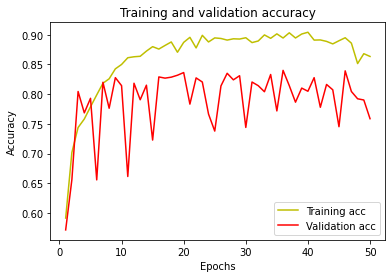

In [ ]:
# Plot the training and validation accuracy at each epoch
acc = history_gender.history['accuracy']
val_acc = history_gender.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Here, we see the accuracy has improved but it is still uneven and not stabilzed.

Accuracy =  0.7586912065439673


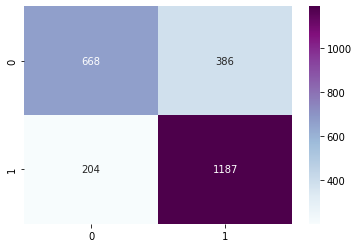

In [ ]:
pred_Gender = ensemble_gender_model.predict(x_test_gender)
y_pred_gender = (pred_Gender>= 0.5).astype(int)[:,0]

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test_gender, y_pred_gender))

# Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(y_test_gender, y_pred_gender)  
sns.heatmap(cm, annot=True, fmt = 'd', cmap = "BuPu")

As seen from the confusion matrix we are able to achieve about 75.86% accuracy which is very good as compared to the combined model accuracy for gender which was 47%. Here as well we only trained the model for 50 epochs if we could have trained for larger epochs we could have achieved few more percentage of good scores.

In [ ]:
pred_gender = []
for i in pred_Gender:
    pred_gender.append(np.round(i[0]))

In [ ]:
def plotGenderPA(image,pred,actual):
    plt.figure(figsize=[22,15])
    for i in range(500,525):
        plt.subplot(5,5,(i%25)+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x_test_gender[i])
        plt.xlabel(f"Actual Gender is {actual[i]}")
        plt.ylabel(f"Prediced is {pred[i]}")
    plt.show()

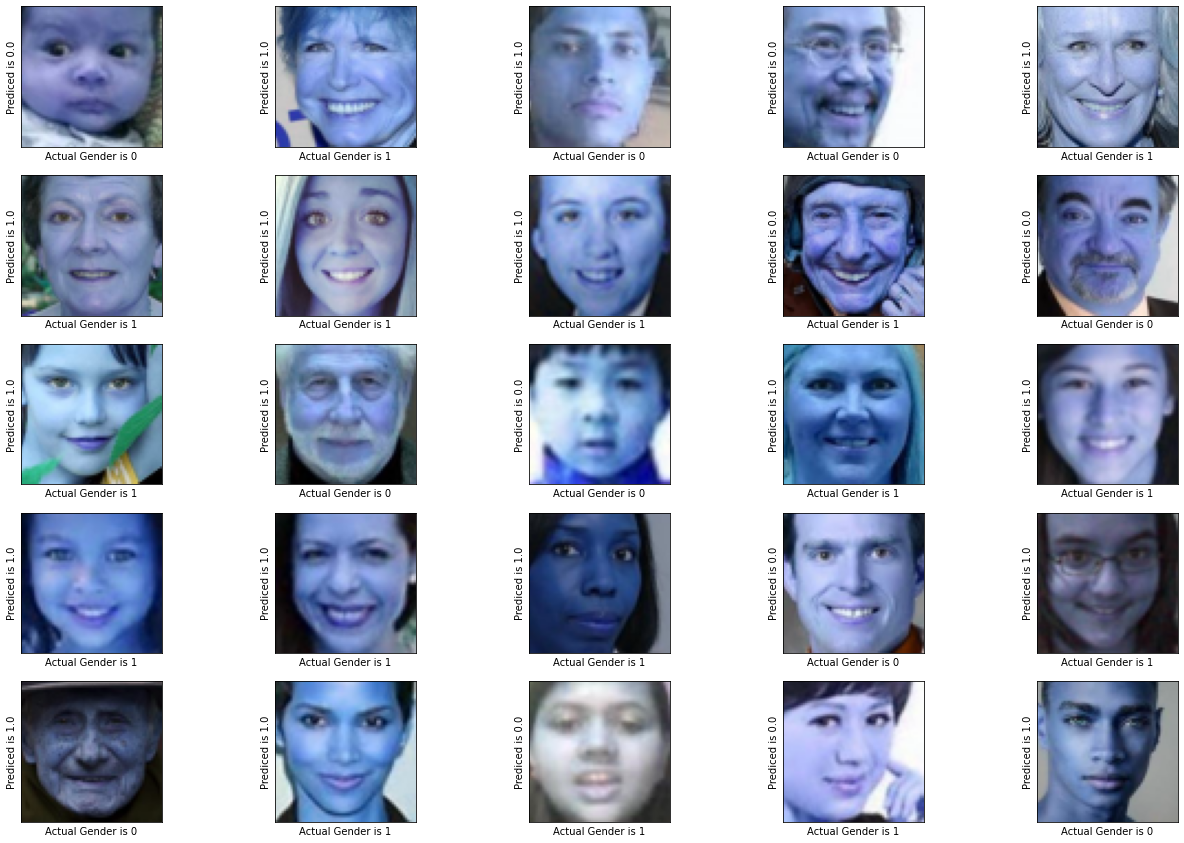

In [ ]:
plotGenderPA(x_test_gender,pred_gender,y_test_gender)

Here, we can see how the model has performed well in predicting the gender for different age groups, except few miss-classification it was correctly able to predict most of the test data.

K-Fold Cross validation for gender data-set

In [ ]:
# Using 10 folds of cross validation data 
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
# Define KFold with number of splits set to 10
strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(x_test_gender, y_test_gender)
scores = []

# Iterate through each k value and test, train data
for k, (train, test) in enumerate(kfold):
  ensemble_gender_model.fit(x_test_gender[train], y_test_gender[train])
  pred_gender = ensemble_gender_model.predict(x_test_gender[test])
  y_pred_gender = (pred_gender>= 0.5).astype(int)[:,0]
  score = metrics.accuracy_score(y_test_gender[test], y_pred_gender)
  scores.append(score)
  print('Fold: %2d, Training/Test Split Distribution: %s, Accuracy: %.3f' % (k+1, np.bincount(y_test_gender[train]), score))

#Print the average accuracy with the deviation
print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

69/69 [==============================] - 3s 42ms/step - loss: 0.6119 - accuracy: 0.7286
Fold:  1, Training/Test Split Distribution: [ 949 1251], Accuracy: 0.776
69/69 [==============================] - 3s 42ms/step - loss: 0.4817 - accuracy: 0.7518
Fold:  2, Training/Test Split Distribution: [ 948 1252], Accuracy: 0.816
69/69 [==============================] - 3s 41ms/step - loss: 0.4961 - accuracy: 0.7482
Fold:  3, Training/Test Split Distribution: [ 948 1252], Accuracy: 0.829
69/69 [==============================] - 3s 42ms/step - loss: 0.4457 - accuracy: 0.7705
Fold:  4, Training/Test Split Distribution: [ 948 1252], Accuracy: 0.837
69/69 [==============================] - 3s 42ms/step - loss: 0.4348 - accuracy: 0.7700
Fold:  5, Training/Test Split Distribution: [ 948 1252], Accuracy: 0.873
69/69 [==============================] - 3s 42ms/step - loss: 0.4215 - accuracy: 0.7796
Fold:  6, Training/Test Split Distribution: [ 949 1252], Accuracy: 0.857
69/69 [===========================

## Impact of varying parameters

In this section we have decided to implement image data augmentation, drop a layer and use L1 regularization to see if we could reduce the overfitting of the data.

## Age Model Regularized

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [ ]:
# Using Image data generator class to add some variations to the data-set
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               shear_range=0.2,
                               horizontal_flip= True
                              )

test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(resized_img, age_label, random_state=42)

In [ ]:
# Applying it to Age data-set
age_train_ds = train_gen.flow(x_train_age,y_train_age,batch_size = 32)

age_test_ds = test_gen.flow(x_test_age,y_test_age,batch_size = 32,shuffle=False)

In [ ]:
# Age model regularized
def ensemble_age_model_regularized(input_shape):

  inputs = keras.Input((input_shape))

  attention_model = simple_cnn_with_attention(inputs)

  resnet_attention_model = resnet34_model(attention_model)

  batch_norm_1 = BatchNormalization()(resnet_attention_model)
  # Removing one drop out layer
  #dropout_1 = Dropout(0.5)(batch_norm_1)

  flatten = Flatten()(batch_norm_1)
  # Passing regularization parameter
  dense_1 = Dense(512, activation='relu', activity_regularizer=regularizers.l1(0.01))(flatten)
  batch_norm_2 = BatchNormalization()(dense_1)
  dropout_2 = Dropout(0.5)(batch_norm_2)
  dense_4 = Dense(128, activation='relu')(dropout_2)
  
  age_output = Dense(1, activation='relu', name='age')(dense_4)


  model = Model(inputs=[inputs], outputs=[age_output])

  return model

In [ ]:
# Calling the model
ensemble_age_model_regularized = ensemble_age_model_regularized((64,64,3))

In [ ]:
# Compiling the model
ensemble_age_model_regularized.compile(loss=["mae"], optimizer="Adam",metrics=["mae"])

In [ ]:
history_age_regularized = ensemble_age_model_regularized.fit(age_train_ds,
                        validation_data=age_test_ds, epochs=50)

Epoch 1/50
230/230 [==============================] - 20s 78ms/step - loss: 17.5920 - mae: 17.4327 - val_loss: 28.0612 - val_mae: 27.8803
Epoch 2/50
230/230 [==============================] - 17s 72ms/step - loss: 13.2686 - mae: 13.1468 - val_loss: 27.1589 - val_mae: 27.0335
Epoch 3/50
230/230 [==============================] - 17s 72ms/step - loss: 11.9917 - mae: 11.8937 - val_loss: 19.7594 - val_mae: 19.7188
Epoch 4/50
230/230 [==============================] - 17s 72ms/step - loss: 11.4080 - mae: 11.3179 - val_loss: 13.6411 - val_mae: 13.5889
Epoch 5/50
230/230 [==============================] - 16s 71ms/step - loss: 11.0883 - mae: 11.0048 - val_loss: 11.0369 - val_mae: 10.9418
Epoch 6/50
230/230 [==============================] - 17s 73ms/step - loss: 10.7176 - mae: 10.6391 - val_loss: 9.2417 - val_mae: 9.1559
Epoch 7/50
230/230 [==============================] - 17s 72ms/step - loss: 10.3728 - mae: 10.2975 - val_loss: 11.0359 - val_mae: 10.9430
Epoch 8/50
230/230 [================

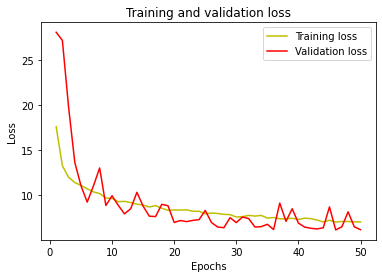

In [ ]:
history = history_age_regularized

# Plot the training and validation loss at each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the above plot for loss we can infer that the model was able to generalize well this time after using the hyperparameters like L1 regularization, dropping a layer and using image data-generator.

In [ ]:
pred_Age_reg = ensemble_age_model_regularized.predict(age_test_ds, verbose=1)

77/77 [==============================] - 1s 15ms/step


In [ ]:
pred_age_reg = []
for i in pred_Age_reg:
    pred_age_reg.append(np.round(i[0]))

## Gender Model Regularized

In [ ]:
# Create test train spit for gender data-set
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(resized_img, gender_label, random_state=42)

In [ ]:
# Creating data-set using image data generator
gender_train_ds = train_gen.flow(x_train_gender,y_train_gender,batch_size = 32)

gender_test_ds = test_gen.flow(x_test_gender,y_test_gender,batch_size = 32,shuffle=False)

In [ ]:
# Gender model regularized
def ensemble_gender_model_regularized(input_shape):

  inputs = keras.Input((input_shape))

  attention_model = simple_cnn_with_attention(inputs)

  resnet_attention_model = resnet34_model(attention_model)

  batch_norm_1 = BatchNormalization()(resnet_attention_model)
  # Removing one drop out layer
  #dropout_1 = Dropout(0.5)(batch_norm_1)

  flatten = Flatten()(batch_norm_1)
  
  # Passing regularization parameter
  dense_1 = Dense(512, activation='relu', activity_regularizer=regularizers.l1(0.01))(flatten)
  batch_norm_2 = BatchNormalization()(dense_1)
  dropout_2 = Dropout(0.5)(batch_norm_2)
  dense_4 = Dense(128, activation='relu')(dropout_2)
  
  gender_output = Dense(1, activation='sigmoid', name='gender')(dense_4)


  model = Model(inputs=[inputs], outputs=[gender_output])

  return model

In [ ]:
# Calling the model
ensemble_gender_model_regularized = ensemble_gender_model_regularized((64,64,3))

In [ ]:
# Adding early-stopping
es = EarlyStopping(patience= 3, restore_best_weights=True)

In [ ]:
# Compiling the model
ensemble_gender_model_regularized.compile(loss=["binary_crossentropy"], optimizer="Adam",metrics=["accuracy"])

In [ ]:
history_gender_regularized = ensemble_gender_model_regularized.fit(gender_train_ds,
                                                             validation_data=gender_test_ds, epochs=50, callbacks=[es])

Epoch 1/50
230/230 [==============================] - 19s 73ms/step - loss: 0.7156 - accuracy: 0.6473 - val_loss: 0.6724 - val_accuracy: 0.6883
Epoch 2/50
230/230 [==============================] - 16s 71ms/step - loss: 0.5627 - accuracy: 0.7174 - val_loss: 0.6056 - val_accuracy: 0.6982
Epoch 3/50
230/230 [==============================] - 17s 72ms/step - loss: 0.5241 - accuracy: 0.7388 - val_loss: 0.4841 - val_accuracy: 0.7616
Epoch 4/50
230/230 [==============================] - 17s 72ms/step - loss: 0.5041 - accuracy: 0.7486 - val_loss: 0.4722 - val_accuracy: 0.7689
Epoch 5/50
230/230 [==============================] - 17s 72ms/step - loss: 0.4914 - accuracy: 0.7601 - val_loss: 0.4728 - val_accuracy: 0.7796
Epoch 6/50
230/230 [==============================] - 17s 73ms/step - loss: 0.4872 - accuracy: 0.7621 - val_loss: 0.5776 - val_accuracy: 0.7366
Epoch 7/50
230/230 [==============================] - 16s 72ms/step - loss: 0.4703 - accuracy: 0.7729 - val_loss: 0.4445 - val_accuracy:

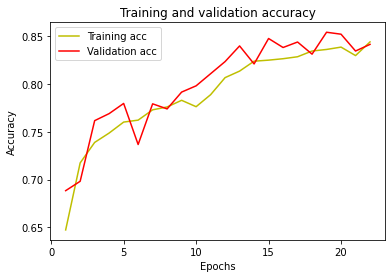

In [ ]:
# Plot the training and validation accuracy at each epoch

acc = history_gender_regularized.history['accuracy']
val_acc = history_gender_regularized.history['val_accuracy']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As we can see from above plots that the model now generalizes well after we have applied L1 regularization on the data-set and dropped a layer. We can see the plots are smoother and there are less uneven spikes.

The accuracy of the gender model has also slightly increased and for the age model the loss has further reduced which implies we were able to make use of varying hyperparameters and improve our model.

In [ ]:
pred_gender_reg = ensemble_gender_model_regularized.predict(gender_test_ds)

In [ ]:
pred_gen_reg = []
for i in pred_gender_reg:
    pred_gen_reg.append(int(np.round(i[0])))

In [ ]:
print(classification_report(pred_gen_reg,y_test_gender))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1157
           1       0.83      0.90      0.87      1288

    accuracy                           0.85      2445
   macro avg       0.86      0.85      0.85      2445
weighted avg       0.86      0.85      0.85      2445



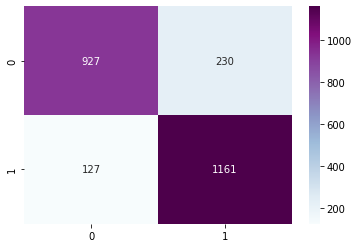

In [ ]:
sns.heatmap(confusion_matrix(pred_gen_reg,y_test_gender),annot = True, fmt = 'd', cmap = "BuPu");

In [ ]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(pred_gen_reg,y_test_gender))

Accuracy =  0.8539877300613496


As we can see the model accuracy has improved after the reguarization. We are able to get about 85.39% accuracy as compared to 75% in the previous model without regularization, which suggests we have made some improvement.

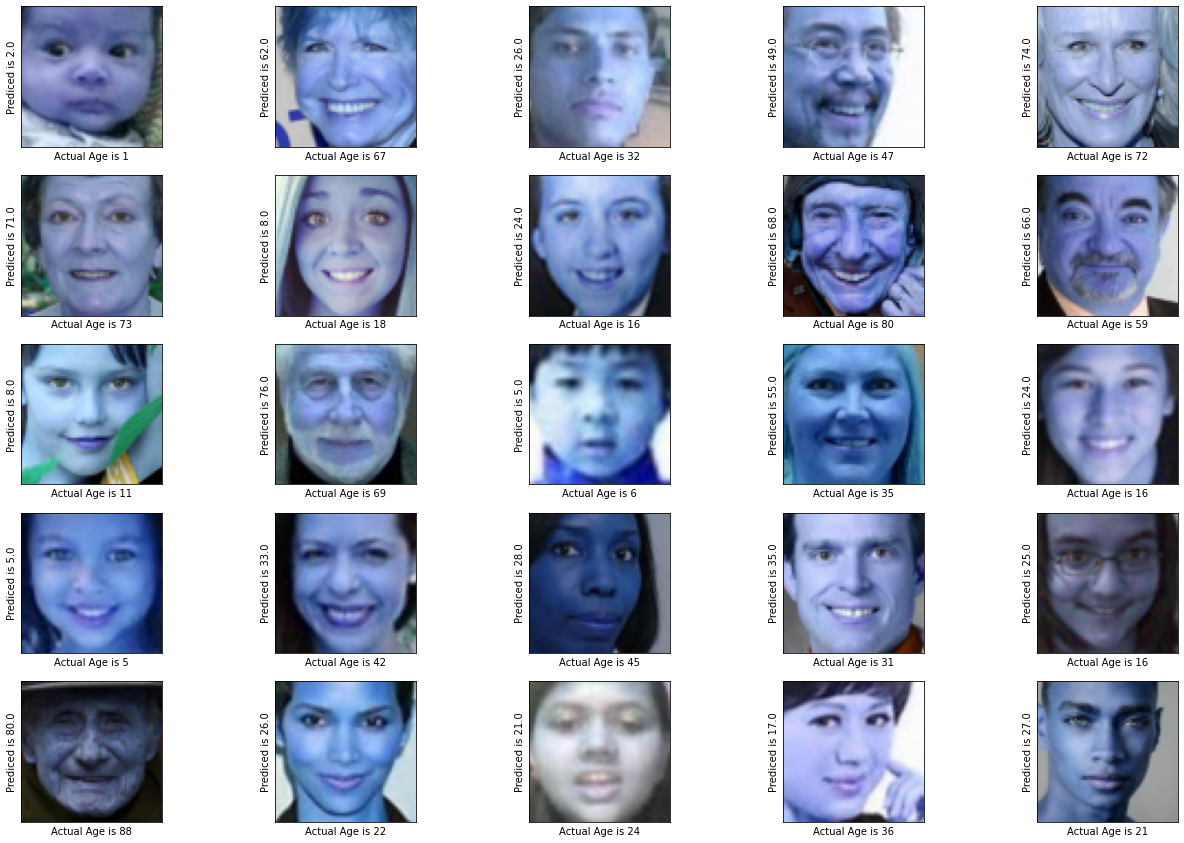

In [ ]:
plotAgePA(x_test_age,pred_age_reg,y_test_age)

Here we can see that after using regularization, the Age prediction has shown some improvement as well. In model without regularization we were getting few wrong predictions for age 1-10 and 90-100 but after regularization we are w=very close to the actual age!

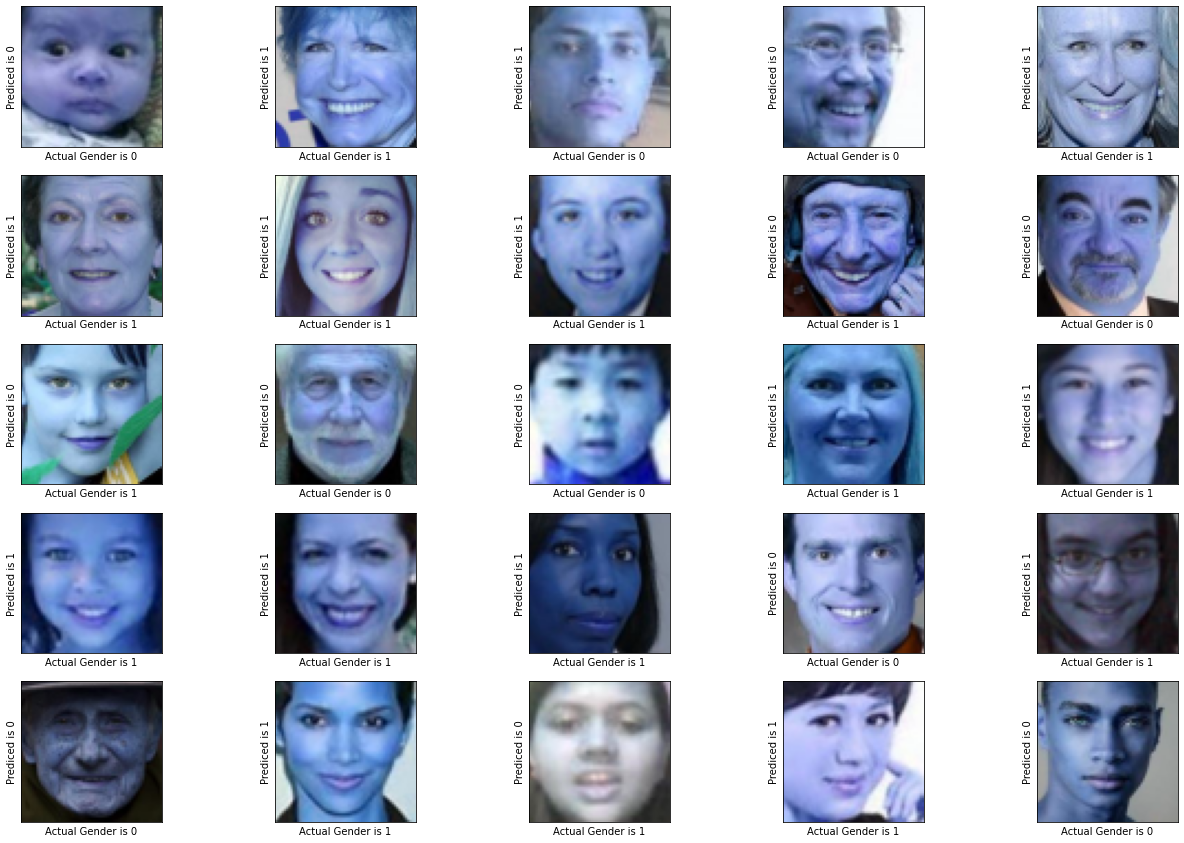

In [ ]:
plotGenderPA(x_test_gender,pred_gen_reg,y_test_gender)

From above plots for Gender data, we can see that after using regularization, we see an improvement in Gender prediction.